In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from deap import base, creator, tools, algorithms
import random
import os
import json
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image

# Carregar e preparar o dataset Titanic

In [13]:
def load_titanic_data():
    url = "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"
    data = pd.read_csv(url)
    print(data.head())
        
    # Remover colunas que não serão usadas
    data = data.drop(['Name'], axis=1)
    
    # Tratar valores ausentes
    data = data.dropna()
    
    # Codificar colunas categóricas
    label_encoder = LabelEncoder()
    data['Sex'] = label_encoder.fit_transform(data['Sex'])
    
    # Separar dados de entrada e saída
    X = data.drop('Survived', axis=1).values
    y = data['Survived'].values

    # Normalizar dados de entrada
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Dividir dados em treino e teste
    return train_test_split(X, y, test_size=0.2, random_state=42)


x_train, x_test, y_train, y_test = load_titanic_data()

   Survived  Pclass                                               Name  \
0         0       3                             Mr. Owen Harris Braund   
1         1       1  Mrs. John Bradley (Florence Briggs Thayer) Cum...   
2         1       3                              Miss. Laina Heikkinen   
3         1       1        Mrs. Jacques Heath (Lily May Peel) Futrelle   
4         0       3                            Mr. William Henry Allen   

      Sex   Age  Siblings/Spouses Aboard  Parents/Children Aboard     Fare  
0    male  22.0                        1                        0   7.2500  
1  female  38.0                        1                        0  71.2833  
2  female  26.0                        0                        0   7.9250  
3  female  35.0                        1                        0  53.1000  
4    male  35.0                        0                        0   8.0500  


# Classe de callback para plotagem dinâmica 

In [14]:
class DynamicPlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, generation, epoch, repo_dir):
        self.generation = generation
        self.epoch = epoch
        self.repo_dir = repo_dir
        self.batch_losses = []
        self.batch_accuracies = []
        self.epoch_losses = []
        self.epoch_accuracies = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_accuracies.append(logs['accuracy'])
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.batch_losses, label='Loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title(f'Generation {self.generation} - Epoch {self.epoch} - Batch {batch}')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.batch_accuracies, label='Accuracy')
        plt.xlabel('Batch')
        plt.ylabel('Accuracy')
        plt.title(f'Generation {self.generation} - Epoch {self.epoch} - Batch {batch}')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_losses.append(logs['loss'])
        self.epoch_accuracies.append(logs['accuracy'])
        print(f"Epoch {epoch + 1} completed.")
        print(f" - Loss: {logs['loss']:.4f}")
        print(f" - Accuracy: {logs['accuracy']:.4f}")
        print(f" - Validation Loss: {logs['val_loss']:.4f}")
        print(f" - Validation Accuracy: {logs['val_accuracy']:.4f}")

        # Salvar estatísticas da época
        epoch_stats = {
            'epoch': epoch + 1,
            'loss': logs['loss'],
            'accuracy': logs['accuracy'],
            'val_loss': logs['val_loss'],
            'val_accuracy': logs['val_accuracy']
        }
        with open(os.path.join(self.repo_dir, f'generation_{self.generation}_epoch_{self.epoch}_stats.json'), 'w') as f:
            json.dump(epoch_stats, f)

# Função para criar a rede neural


In [15]:
def create_nn(hp):
    model = Sequential()
    model.add(Dense(hp['dense_units'], activation='relu', input_shape=(x_train.shape[1],)))
    model.add(Dropout(hp['dropout_rate']))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = hp['optimizer'](learning_rate=hp['learning_rate'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Função para avaliar um indivíduo

In [16]:
def evaluate(individual, generation, epoch, repo_dir):
    hp = {
        'dense_units': int(individual[0]),
        'dropout_rate': individual[1],
        'optimizer': {'adam': Adam, 'sgd': SGD, 'rmsprop': RMSprop}[individual[2]],
        'batch_size': int(individual[3]),
        'learning_rate': individual[4]
    }

    model = create_nn(hp)

    dynamic_plot_callback = DynamicPlotCallback(generation=generation, epoch=epoch, repo_dir=repo_dir)

    history = model.fit(
        x_train, y_train,
        epochs=1,
        batch_size=hp['batch_size'],
        validation_data=(x_test, y_test),
        verbose=0,
        callbacks=[dynamic_plot_callback]
    )

    _, accuracy = model.evaluate(x_test, y_test, verbose=0)
    return accuracy

# Configuração do DEAP

In [17]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 16, 128)
toolbox.register("attr_dropout", random.uniform, 0.2, 0.5)
toolbox.register("attr_optimizer", random.choice, ['adam', 'sgd', 'rmsprop'])
toolbox.register("attr_batch_size", random.choice, [16, 32, 64])
toolbox.register("attr_learning_rate", random.uniform, 1e-4, 1e-2)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_int, toolbox.attr_dropout, toolbox.attr_optimizer,
                  toolbox.attr_batch_size, toolbox.attr_learning_rate), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# População inicial

In [18]:
population = toolbox.population(n=10)
NGEN = 3
CXPB = 0.5
MUTPB = 0.2

gen_accuracies = []
best_accuracies = []

# Criar diretório para armazenar estatísticas

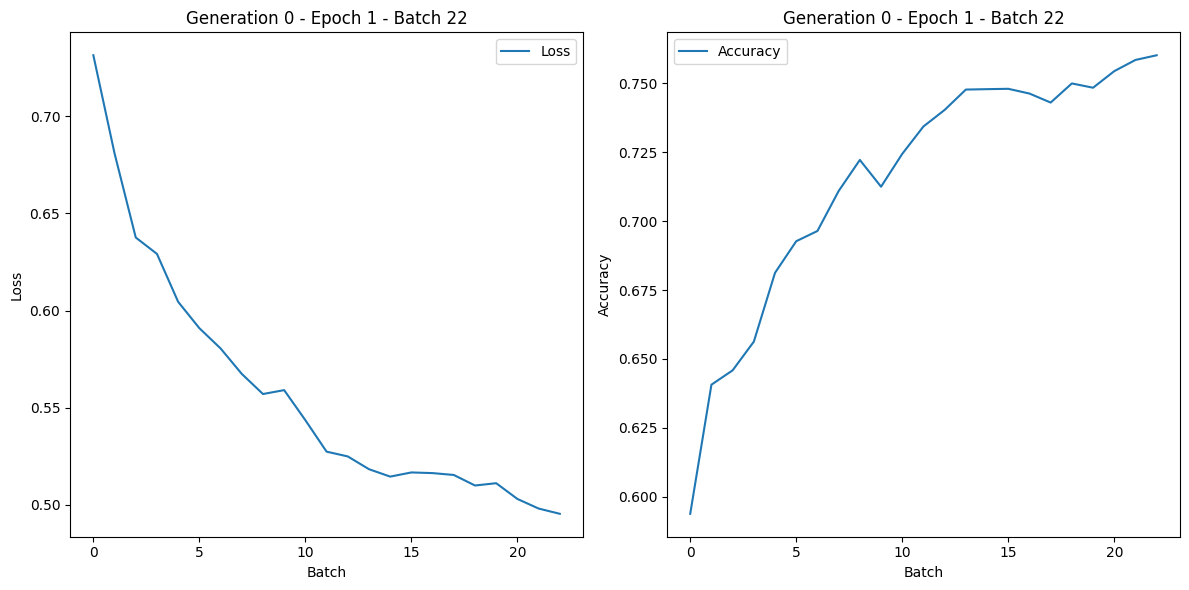

Epoch 1 completed.
 - Loss: 0.4954
 - Accuracy: 0.7602
 - Validation Loss: 0.5089
 - Validation Accuracy: 0.7584


KeyError: 'False'

In [19]:
# Criar diretório para salvar os resultados
repo_dir = 'training_repo' # Diretório para salvar os resultados
os.makedirs(repo_dir, exist_ok=True) # Cria o diretório se ele não existir

# Salvar hiperparâmetros da população inicial em um arquivo JSON para referência 
for gen in range(NGEN): # loop sobre as gerações no range número de gerações
    print(f"-- Geração {gen} --")
    current_generation = gen # Salvar a geração atual para referência

    for epoch in range(2): # loop sobre as épocas no range número de épocas, que é 2, sendo que o 0 é a primeira época
        current_epoch = epoch # Salvar a época atual para referência

        # Avalia a aptidão de cada indivíduo na população
        fitnesses = list(map(lambda ind: toolbox.evaluate(ind, current_generation, current_epoch, repo_dir), population)) # Avalia a aptidão de cada indivíduo na população

        # Atribui os valores de aptidão calculados aos indivíduos da população
        for ind, fit in zip(population, fitnesses): # Loop sobre os indivíduos e suas respectivas aptidões, cria uma tupla com a aptidão, sendo que fitnesses é uma lista de aptidões
            ind.fitness.values = (fit,)  # Converte o valor de fitness em uma tupla de um único elemento

        # Calcula as precisões de aptidão para cada indivíduo
        accuracies = [ind.fitness.values[0] for ind in population] # Cria uma lista com as precisões de aptidão para cada indivíduo por meio do loop sobre a população

        # Adiciona a média das precisões à lista de precisões por geração
        gen_accuracies.append(np.mean(accuracies)) 
        best_accuracies.append(max(accuracies)) # Adiciona a melhor precisão à lista de precisões, por geração

    offspring = toolbox.select(population, len(population)) # Seleciona os indivíduos que irão se reproduzir no length da população
    offspring = list(map(toolbox.clone, offspring)) # Clona os indivíduos selecionados, pois os clones dos indivíduos originais serão modificados, enquanto os originais serão mantidos

    for child1, child2 in zip(offspring[::2], offspring[1::2]): # Loop sobre os indivíduos da população, de dois em dois, com zip e slicing, para garantir que os indivíduos sejam emparelhados
        if random.random() < CXPB: # Verifica se um valor é menor que a probabilidade de cruzamento, aleatório entre 0 e 1, o que serve para estoocasticidade do cruzamento
            toolbox.mate(child1, child2) # Realiza o cruzamento entre os dois indivíduos, escolhidos aleatoriamente
            del child1.fitness.values # Deleta os valores de aptidão dos indivíduos, pois eles serão recalculados na reprodução
            del child2.fitness.values 

    for mutant in offspring: # Loop sobre os indivíduos da população, sendo mutant um indivíduo da população que sofrerá mutação (alteração de um ou mais genes)
        if random.random() < MUTPB: # Verifica se um valor é menor que a probabilidade de mutação, aleatório entre 0 e 1, o que serve para estoocasticidade da mutação
            toolbox.mutate(mutant) # Realiza a mutação do indivíduo, alterando um ou mais genes
            del mutant.fitness.values # Deleta os valores de aptidão dos indivíduos, pois eles serão recalculados na mutação

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid] # Cria uma lista de indivíduos inválidos no offspring se não tiverem aptidão válida
    fitnesses = map(lambda ind: toolbox.evaluate(ind, current_generation, current_epoch, repo_dir), invalid_ind) # Define as aptidões dos indivíduos inválidos
    for ind, fit in zip(invalid_ind, fitnesses): # Loop sobre os indivíduos inválidos e suas respectivas aptidões, cria uma tupla com a aptidão, sendo que fitnesses é uma lista de aptidões
        ind.fitness.values = (fit,)  # fit é uma tupla de um único elemento, que é a aptidão do indivíduo

    population[:] = offspring # Substitui a população pela prole; o slicing [:] é usado para manter a referência da lista original

best_ind = tools.selBest(population, 1)[0] # Seleciona o melhor indivíduo da população dentro de cada geração
print(f"Melhor indivíduo: {best_ind}, Acurácia: {best_ind.fitness.values[0]}") # Imprime o melhor indivíduo e sua aptidão

plt.figure(figsize=(10, 5)) # Define o tamanho da figura
plt.plot(gen_accuracies, label='Acurácia Média') # Plota a acurácia média
plt.plot(best_accuracies, label='Melhor Acurácia') # Plota a melhor acurácia
plt.xlabel('Geração') 
plt.ylabel('Acurácia')
plt.legend() 
plt.title('Evolução da Acurácia ao Longo das Gerações')
plt.show()

# Melhores hiperparâmetros
best_hp = { 
    'dense_units': int(best_ind[0]),
    'dropout_rate': best_ind[1],
    'optimizer': best_ind[2],
    'batch_size': best_ind[3],
    'learning_rate': best_ind[4]
}



# Comparação com algoritmos tradicionais

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

# Carregar os dados 
url = "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"
data = pd.read_csv(url)

# Remover coluna que não será usada
data = data.drop(['Name'], axis=1)

# Tratar valores ausentes
data = data.dropna()

# Codificar colunas categóricas
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])

# Separar dados de entrada e saída
X = data.drop('Survived', axis=1).values
y = data['Survived'].values

# Normalizar dados de entrada
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def train_knn(X_train, y_train, X_test):
    """
    Treina um classificador KNN e retorna as previsões para o conjunto de teste.
    """
    knn = KNeighborsClassifier(n_neighbors=5)  # Inicializa o classificador KNN
    knn.fit(X_train, y_train)  # Treina o classificador
    return knn.predict(X_test)

def train_random_forest(X_train, y_train, X_test):
    """
    Treina um classificador Random Forest e retorna as previsões para o conjunto de teste.
    """
    rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Inicializa o classificador Random Forest
    rf.fit(X_train, y_train)  # Treina o classificador
    return rf.predict(X_test)

def train_svm(X_train, y_train, X_test):
    """
    Treina um classificador SVM e retorna as previsões para o conjunto de teste.
    """
    svm = SVC(kernel='linear', random_state=42)  # Inicializa o classificador SVM
    svm.fit(X_train, y_train)  # Treina o classificador
    return svm.predict(X_test)

def train_naive_bayes(X_train, y_train, X_test):
    """
    Treina um classificador Naive Bayes e retorna as previsões para o conjunto de teste.
    """
    nb = GaussianNB()  # Inicializa o classificador Naive Bayes
    nb.fit(X_train, y_train)  # Treina o classificador
    return nb.predict(X_test)

# Treinar e avaliar KNN
knn_predictions = train_knn(X_train, y_train, X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)
print("KNN Classification Report:\n", classification_report(y_test, knn_predictions))

# Treinar e avaliar Random Forest
rf_predictions = train_random_forest(X_train, y_train, X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_predictions))

# Treinar e avaliar SVM
svm_predictions = train_svm(X_train, y_train, X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)
print("SVM Classification Report:\n", classification_report(y_test, svm_predictions))

# Treinar e avaliar Naive Bayes
nb_predictions = train_naive_bayes(X_train, y_train, X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_predictions))

# Plotar gráficos de acurácia
classifiers = ['KNN', 'Random Forest', 'SVM', 'Naive Bayes', 'Genetic NN']
accuracies = [knn_accuracy, rf_accuracy, svm_accuracy, nb_accuracy, best_accuracies]

plt.figure(figsize=(10, 6))
plt.bar(classifiers, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Classificador')
plt.ylabel('Acurácia')
plt.title('Acurácia dos Classificadores')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom')
plt.show()

KNN Accuracy: 0.7808988764044944
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83       111
           1       0.71      0.70      0.71        67

    accuracy                           0.78       178
   macro avg       0.77      0.77      0.77       178
weighted avg       0.78      0.78      0.78       178

Random Forest Accuracy: 0.7696629213483146
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82       111
           1       0.70      0.67      0.69        67

    accuracy                           0.77       178
   macro avg       0.76      0.75      0.75       178
weighted avg       0.77      0.77      0.77       178

SVM Accuracy: 0.7415730337078652
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81       111
           1       0.71      0.54 

NameError: name 'best_accuracies' is not defined